# Предсказатель времени сборки

**Цель проекта:** 

Научить *ML* предсказывать время сборки заказа в секундах, чтобы знать когда вызывать курьеров доставки

## Изучение данных

In [1]:
# Загрузка Библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from helpers import DateTimeConverter, UnknownCategoryImputer, MultiColumnLabelEncoder

from catboost import CatBoostRegressor

from time import time

import joblib

import warnings
warnings.filterwarnings("ignore")

import locale

# Установим локаль на русский
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

# Установим параметр, чтобы отображать все колонки при выводе
pd.set_option('display.max_columns', None)

# Ограничение числа знаков после запятой до 2
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df_test = pd.read_csv('data/process_df_orders.csv')

In [3]:
df_test

order_id  shop_id region  darkstore  \
0        64c9737a757b3c84f07be56d     4336    spb      False   
1        64c9738f757b3c368b7be571     4336    spb      False   
2        64c9739a5d894414d6f733ad     4336    spb      False   
3        64c9774141cc46d0d3cffbd0     3561    ekb      False   
4        64c977c9e2dccf6f8756d4c5     4336    spb      False   
...                           ...      ...    ...        ...   
2964924  64dd3509705aef13507106a1     1174    spb      False   
2964925  64dd355a3a7142c3a86ef99f     4336    spb      False   
2964926  64dd35f865ddb0509cef33f0     4336    spb      False   
2964927  64dd3803a285f5c5aace3704     1174    spb      False   
2964928  64dd3855705aef280a710760     1174    spb      False   

                       date_ready           date_collecting  products_count  \
0        2023-08-01T21:40:30.555Z  2023-08-01T21:37:34.699Z               3   
1        2023-08-01T21:53:37.644Z  2023-08-01T21:41:15.525Z               9   
2        2023-08-01T22:01:43.882Z  2023-08-01T21:43:29.384Z              24   
3        2023-08-01T21:42:50.881Z  2023-08-01T21:25:13.001Z               7   
4        2023-08-01T22:17:23.758Z  2023-08-01T22:10:57.988Z              12   
...                           ...                       ...             ...   
2964924  2023-08-16T21:02:42.697Z  2023-08-16T20:44:50.734Z               1   
2964925  2023-08-16T20:48:31.075Z  2023-08-16T20:45:30.394Z               2   
2964926  2023-08-16T20:51:25.739Z  2023-08-16T20:48:36.106Z               2   
2964927  2023-08-16T21:18:18.650Z  2023-08-16T21:06:11.184Z              11   
2964928  2023-08-16T21:25:02.532Z  2023-08-16T21:19:48.129Z               5   

         quantity_no_weight_products  weight_of_weight_products  marked_count  \
0                               3.00                       0.00             0   
1                              18.00                       0.00             0   
2                              23.00                       3.60             4   
3                               7.00                       0.00             1   
4                              17.00                       0.81             3   
...                              ...                        ...           ...   
2964924                        21.00                       0.00             1   
2964925                         4.00                       0.00             2   
2964926                        15.00                       0.00             0   
2964927                        12.00                       0.54             2   
2964928                         5.00                       0.00             3   

         weight_count  
0                   0  
1                   0  
2                   6  
3                   0  
4                   1  
...               ...  
2964924             0  
2964925             0  
2964926             1  
2964927             1  
2964928             0  

[2964929 rows x 11 columns]

In [4]:
item = {
    "region": "msk",
    "darkstore": False,
    "products_count": 5,
    "quantity_no_weight_products": 5,
    "weight_of_weight_products": 3.70,
    "marked_count": 1,
    "weight_count": 2,
    "freeze_products": False,
    "pay_on_packing": False,
    "replacement_type": "ask",
    "replacement_need_call": False,
    "shop_group": "fivedelivery",
    "date_collecting": "2023-08-01T21:40:30.555Z",
    "shop_timezone_offset": 180
}

In [5]:
item_df = pd.DataFrame([dict(item)])

In [6]:
item_df

region  darkstore  products_count  quantity_no_weight_products  \
0    msk      False               5                            5   

   weight_of_weight_products  marked_count  weight_count  freeze_products  \
0                       3.70             1             2            False   

   pay_on_packing replacement_type  replacement_need_call    shop_group  \
0           False              ask                  False  fivedelivery   

            date_collecting  shop_timezone_offset  
0  2023-08-01T21:40:30.555Z                   180

In [7]:
item_df

region  darkstore  products_count  quantity_no_weight_products  \
0    msk      False               5                            5   

   weight_of_weight_products  marked_count  weight_count  freeze_products  \
0                       3.70             1             2            False   

   pay_on_packing replacement_type  replacement_need_call    shop_group  \
0           False              ask                  False  fivedelivery   

            date_collecting  shop_timezone_offset  
0  2023-08-01T21:40:30.555Z                   180

In [8]:
# Функция для парсинга дат
def custom_date_parser(date_string):
    timestamp = pd.to_datetime(date_string, format='%Y-%m-%dT%H:%M:%S.%fZ')
    localized_timestamp = timestamp.tz_localize(None)
    truncated_timestamp = localized_timestamp.floor('s')
    return truncated_timestamp

# Список столбцов с датами
columns_to_convert = [
    'date_collecting',
    'date_ready'
]

# Чтение CSV файла с явным указанием формата дат
df = pd.read_csv('data/process_df_orders.csv', parse_dates=columns_to_convert, date_parser=custom_date_parser)

# Теперь столбцы указанных дат имеют тип datetime
print(df.dtypes)

order_id                               object
shop_id                                 int64
region                                 object
darkstore                                bool
date_ready                     datetime64[ns]
date_collecting                datetime64[ns]
products_count                          int64
quantity_no_weight_products           float64
weight_of_weight_products             float64
marked_count                            int64
weight_count                            int64
dtype: object


In [9]:
df

order_id  shop_id region  darkstore  \
0        64c9737a757b3c84f07be56d     4336    spb      False   
1        64c9738f757b3c368b7be571     4336    spb      False   
2        64c9739a5d894414d6f733ad     4336    spb      False   
3        64c9774141cc46d0d3cffbd0     3561    ekb      False   
4        64c977c9e2dccf6f8756d4c5     4336    spb      False   
...                           ...      ...    ...        ...   
2964924  64dd3509705aef13507106a1     1174    spb      False   
2964925  64dd355a3a7142c3a86ef99f     4336    spb      False   
2964926  64dd35f865ddb0509cef33f0     4336    spb      False   
2964927  64dd3803a285f5c5aace3704     1174    spb      False   
2964928  64dd3855705aef280a710760     1174    spb      False   

                 date_ready     date_collecting  products_count  \
0       2023-08-01 21:40:30 2023-08-01 21:37:34               3   
1       2023-08-01 21:53:37 2023-08-01 21:41:15               9   
2       2023-08-01 22:01:43 2023-08-01 21:43:29              24   
3       2023-08-01 21:42:50 2023-08-01 21:25:13               7   
4       2023-08-01 22:17:23 2023-08-01 22:10:57              12   
...                     ...                 ...             ...   
2964924 2023-08-16 21:02:42 2023-08-16 20:44:50               1   
2964925 2023-08-16 20:48:31 2023-08-16 20:45:30               2   
2964926 2023-08-16 20:51:25 2023-08-16 20:48:36               2   
2964927 2023-08-16 21:18:18 2023-08-16 21:06:11              11   
2964928 2023-08-16 21:25:02 2023-08-16 21:19:48               5   

         quantity_no_weight_products  weight_of_weight_products  marked_count  \
0                               3.00                       0.00             0   
1                              18.00                       0.00             0   
2                              23.00                       3.60             4   
3                               7.00                       0.00             1   
4                              17.00                       0.81             3   
...                              ...                        ...           ...   
2964924                        21.00                       0.00             1   
2964925                         4.00                       0.00             2   
2964926                        15.00                       0.00             0   
2964927                        12.00                       0.54             2   
2964928                         5.00                       0.00             3   

         weight_count  
0                   0  
1                   0  
2                   6  
3                   0  
4                   1  
...               ...  
2964924             0  
2964925             0  
2964926             1  
2964927             1  
2964928             0  

[2964929 rows x 11 columns]

In [10]:
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964929 entries, 0 to 2964928
Data columns (total 11 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   order_id                     object        
 1   shop_id                      int64         
 2   region                       object        
 3   darkstore                    bool          
 4   date_ready                   datetime64[ns]
 5   date_collecting              datetime64[ns]
 6   products_count               int64         
 7   quantity_no_weight_products  float64       
 8   weight_of_weight_products    float64       
 9   marked_count                 int64         
 10  weight_count                 int64         
dtypes: bool(1), datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 229.0+ MB


order_id  shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d     4336    spb      False 2023-08-01 21:40:30   
1  64c9738f757b3c368b7be571     4336    spb      False 2023-08-01 21:53:37   
2  64c9739a5d894414d6f733ad     4336    spb      False 2023-08-01 22:01:43   
3  64c9774141cc46d0d3cffbd0     3561    ekb      False 2023-08-01 21:42:50   
4  64c977c9e2dccf6f8756d4c5     4336    spb      False 2023-08-01 22:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-01 21:37:34               3                         3.00   
1 2023-08-01 21:41:15               9                        18.00   
2 2023-08-01 21:43:29              24                        23.00   
3 2023-08-01 21:25:13               7                         7.00   
4 2023-08-01 22:10:57              12                        17.00   

   weight_of_weight_products  marked_count  weight_count  
0                       0.00             0             0  
1                       0.00             0             0  
2                       3.60             4             6  
3                       0.00             1             0  
4                       0.81             3             1

In [11]:
# Чтение CSV файла
df2 = pd.read_csv('data/add_flags.csv')

In [12]:
df2.info()
display(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076776 entries, 0 to 3076775
Data columns (total 25 columns):
 #   Column                                            Dtype 
---  ------                                            ----- 
 0   _id                                               object
 1   options.pickup.takeaway                           bool  
 2   options.pickup.code                               int64 
 3   options.promocode                                 object
 4   options.max_weight                                int64 
 5   options.fast_food                                 bool  
 6   options.mature_products                           bool  
 7   options.freeze_products                           bool  
 8   options.client_first_order                        bool  
 9   payment.pay_on_packing                            bool  
 10  payment.started                                   bool  
 11  payment.complete                                  bool  
 12  payment.partne

_id  options.pickup.takeaway  options.pickup.code  \
0  64c9737a757b3c84f07be56d                     True                    0   
1  64c9738f757b3c368b7be571                     True                    0   
2  64c9739a5d894414d6f733ad                     True                    0   
3  64c9774141cc46d0d3cffbd0                     True                    0   
4  64c977c9e2dccf6f8756d4c5                     True                    0   

  options.promocode  options.max_weight  options.fast_food  \
0               NaN                  50              False   
1               NaN                  50              False   
2               NaN                  50              False   
3               NaN                  50              False   
4               NaN                  50              False   

   options.mature_products  options.freeze_products  \
0                    False                    False   
1                    False                     True   
2                    False                     True   
3                    False                     True   
4                    False                    False   

   options.client_first_order  payment.pay_on_packing  payment.started  \
0                       False                    True             True   
1                       False                    True             True   
2                       False                    True             True   
3                       False                    True             True   
4                       False                    True             True   

   payment.complete  payment.partner_confirm payment.method         id  \
0              True                     True        by_card  547932132   
1              True                     True        by_card  547316324   
2              True                     True        by_card  547073323   
3              True                     True        by_card  547702965   
4              True                     True        by_card  547819765   

  replacement.type replacement.need_call  replacement.confirmed  \
0           delete                  True                  False   
1           delete                  True                  False   
2           delete                  True                  False   
3           delete                  True                  False   
4           delete                  True                  False   

   interval_delivery.enabled options.loyalty_card  \
0                      False                  NaN   
1                      False                  NaN   
2                      False                  NaN   
3                      False                  NaN   
4                      False                  NaN   

  interval_delivery.target_delivery_datetime  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

  interval_delivery.target_delivery_datetime_start  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4                                              NaN   

  interval_delivery.target_delivery_datetime_end replacement.timeout  \
0                                            NaN                 NaN   
1                                            NaN                 NaN   
2                                            NaN                 NaN   
3                                            NaN                 NaN   
4                                            NaN                 NaN   

  options.loyalty  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [13]:
df2 = df2.drop(columns=['options.pickup.code', 'options.promocode', 'options.max_weight',
                        'payment.started', 'payment.complete', 'payment.partner_confirm',
                        'payment.method', 'id', 'replacement.confirmed', 'options.loyalty_card', 
                        'interval_delivery.target_delivery_datetime', 'interval_delivery.target_delivery_datetime_start',
                        'interval_delivery.target_delivery_datetime_end', 'replacement.timeout', 'options.loyalty'])

In [14]:
df2 = df2.rename(columns={'_id': 'order_id', 'options.pickup.takeaway': 'pickup_takeaway', 
                          'options.fast_food': 'fast_food', 'options.mature_products': 'mature_products',
                          'options.freeze_products': 'freeze_products', 'options.client_first_order': 'client_first_order',
                          'payment.pay_on_packing': 'pay_on_packing', 'replacement.type': 'replacement_type',
                          'replacement.need_call': 'replacement_need_call', 'interval_delivery.enabled': 'interval_delivery_enabled'})

In [15]:
df2.info()
display(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076776 entries, 0 to 3076775
Data columns (total 10 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   order_id                   object
 1   pickup_takeaway            bool  
 2   fast_food                  bool  
 3   mature_products            bool  
 4   freeze_products            bool  
 5   client_first_order         bool  
 6   pay_on_packing             bool  
 7   replacement_type           object
 8   replacement_need_call      object
 9   interval_delivery_enabled  bool  
dtypes: bool(7), object(3)
memory usage: 91.0+ MB


order_id  pickup_takeaway  fast_food  mature_products  \
0  64c9737a757b3c84f07be56d             True      False            False   
1  64c9738f757b3c368b7be571             True      False            False   
2  64c9739a5d894414d6f733ad             True      False            False   
3  64c9774141cc46d0d3cffbd0             True      False            False   
4  64c977c9e2dccf6f8756d4c5             True      False            False   

   freeze_products  client_first_order  pay_on_packing replacement_type  \
0            False               False            True           delete   
1             True               False            True           delete   
2             True               False            True           delete   
3             True               False            True           delete   
4            False               False            True           delete   

  replacement_need_call  interval_delivery_enabled  
0                  True                      False  
1                  True                      False  
2                  True                      False  
3                  True                      False  
4                  True                      False

In [16]:
pd.DataFrame(round(df2.isna().mean() * 100)).style.background_gradient('coolwarm')

- `pickup_takeaway` - это значит что заказ идет на самовывоз. Особенностей по сборке вроде бы нет, не должно быть влияния
- `fast_food` - не уверена, что есть влияние, но проверить надо
- `mature_products` - готовая еда. По идее может быть влияние - разогреть еду. Не факт что есть
- `freeze_products` - заморозка. Влияние может быть, т.к. надо идти до холодильников и доставать пакеты морозильные
- `client_first_order` - флаг первого заказа, скорее всего не влияет на скорость сборки, но можно проверить
- `pay_on_packing` - оплата на фасовке. Если есть, может замедлить либо ускорить процесс фасовки
- `replacement_type`- тип замен. Влияние высокое. ask - спрашивать клиента, not ask - не спрашивать
- `replacement_need_call` - есть ли звонящая сборка. если true - есть, остальное - нет. Большое количество nan'ов объясняется тем, что звонящая сборка не во всех магазинах раскатана, поэтому пропуски можно заполнить значением False
- `interval_delivery_enabled` - это интервальная доставка, отложенная. влияния скорее всего нет

In [17]:
# Объединение датасетов
df_full_without_gmt = df.merge(df2, on=['order_id'], how='inner')

In [18]:
df_full_without_gmt.info()
display(df_full_without_gmt.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964929 entries, 0 to 2964928
Data columns (total 20 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   order_id                     object        
 1   shop_id                      int64         
 2   region                       object        
 3   darkstore                    bool          
 4   date_ready                   datetime64[ns]
 5   date_collecting              datetime64[ns]
 6   products_count               int64         
 7   quantity_no_weight_products  float64       
 8   weight_of_weight_products    float64       
 9   marked_count                 int64         
 10  weight_count                 int64         
 11  pickup_takeaway              bool          
 12  fast_food                    bool          
 13  mature_products              bool          
 14  freeze_products              bool          
 15  client_first_order           bool          
 16  

order_id  shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d     4336    spb      False 2023-08-01 21:40:30   
1  64c9738f757b3c368b7be571     4336    spb      False 2023-08-01 21:53:37   
2  64c9739a5d894414d6f733ad     4336    spb      False 2023-08-01 22:01:43   
3  64c9774141cc46d0d3cffbd0     3561    ekb      False 2023-08-01 21:42:50   
4  64c977c9e2dccf6f8756d4c5     4336    spb      False 2023-08-01 22:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-01 21:37:34               3                         3.00   
1 2023-08-01 21:41:15               9                        18.00   
2 2023-08-01 21:43:29              24                        23.00   
3 2023-08-01 21:25:13               7                         7.00   
4 2023-08-01 22:10:57              12                        17.00   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type replacement_need_call  \
0            True           delete                  True   
1            True           delete                  True   
2            True           delete                  True   
3            True           delete                  True   
4            True           delete                  True   

   interval_delivery_enabled  
0                      False  
1                      False  
2                      False  
3                      False  
4                      False

In [19]:
# Удаление пропусков replacement_need_call
df_full_without_gmt['replacement_need_call'] = df_full_without_gmt['replacement_need_call'].fillna(False)

In [20]:
pd.DataFrame(round(df_full_without_gmt.isna().mean() * 100)).style.background_gradient('coolwarm')

In [21]:
df3 = pd.read_csv('data/gmt_time.csv')

In [22]:
df3.info()
display(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966515 entries, 0 to 2966514
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   _id                        object 
 1   id                         int64  
 2   shop.redirection.use       bool   
 3   shop.id                    int64  
 4   shop.external_id           object 
 5   shop.city                  object 
 6   shop.group                 object 
 7   shop.address               object 
 8   shop.contact.phone         float64
 9   shop.contact.name          object 
 10  shop.darkstore             bool   
 11  shop.core.id               int64  
 12  shop.timezone              object 
 13  shop.timezone_offset       int64  
 14  shop.redirection.from      float64
 15  shop.redirection.from_sap  object 
 16  shop.max_weight            float64
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 345.1+ MB


_id         id  shop.redirection.use  shop.id  \
0  64c9737a757b3c84f07be56d  547932132                 False     4336   
1  64c9738f757b3c368b7be571  547316324                 False     4336   
2  64c9739a5d894414d6f733ad  547073323                 False     4336   
3  64c9774141cc46d0d3cffbd0  547702965                 False     3561   
4  64c977c9e2dccf6f8756d4c5  547819765                 False     4336   

  shop.external_id shop.city shop.group  \
0             B112       spb        tsx   
1             B112       spb        tsx   
2             B112       spb        tsx   
3             2579       ekb        tsx   
4             B112       spb        tsx   

                                shop.address  shop.contact.phone  \
0  Санкт-Петербург, пр-т Художников, д. 13к1                 NaN   
1  Санкт-Петербург, пр-т Художников, д. 13к1                 NaN   
2  Санкт-Петербург, пр-т Художников, д. 13к1                 NaN   
3         Екатеринбург г, улица 8 марта, 188                 NaN   
4  Санкт-Петербург, пр-т Художников, д. 13к1                 NaN   

  shop.contact.name  shop.darkstore  shop.core.id       shop.timezone  \
0               NaN           False          4336       Europe/Moscow   
1               NaN           False          4336       Europe/Moscow   
2               NaN           False          4336       Europe/Moscow   
3               NaN           False          3561  Asia/Yekaterinburg   
4               NaN           False          4336       Europe/Moscow   

   shop.timezone_offset  shop.redirection.from shop.redirection.from_sap  \
0                   180                    NaN                       NaN   
1                   180                    NaN                       NaN   
2                   180                    NaN                       NaN   
3                   300                    NaN                       NaN   
4                   180                    NaN                       NaN   

   shop.max_weight  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [23]:
df3 = df3.drop(columns=['shop.redirection.use', 'shop.external_id', 'id', 'shop.timezone',
                        'shop.city', 'shop.address', 'shop.contact.phone', 'shop.contact.name',
                        'shop.darkstore', 'shop.core.id', 'shop.redirection.from',
                        'shop.redirection.from_sap', 'shop.max_weight', 'shop.id'])

In [24]:
df3 = df3.rename(columns={'_id': 'order_id', 'shop.group': 'shop_group', 'shop.timezone_offset': 'shop_timezone_offset'})

In [25]:
df3.info()
display(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966515 entries, 0 to 2966514
Data columns (total 3 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   order_id              object
 1   shop_group            object
 2   shop_timezone_offset  int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ MB


order_id shop_group  shop_timezone_offset
0  64c9737a757b3c84f07be56d        tsx                   180
1  64c9738f757b3c368b7be571        tsx                   180
2  64c9739a5d894414d6f733ad        tsx                   180
3  64c9774141cc46d0d3cffbd0        tsx                   300
4  64c977c9e2dccf6f8756d4c5        tsx                   180

In [26]:
# Объединение датасетов
df_full = df_full_without_gmt.merge(df3, on=['order_id'], how='inner')

In [27]:
df_full.info()
display(df_full.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964648 entries, 0 to 2964647
Data columns (total 22 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   order_id                     object        
 1   shop_id                      int64         
 2   region                       object        
 3   darkstore                    bool          
 4   date_ready                   datetime64[ns]
 5   date_collecting              datetime64[ns]
 6   products_count               int64         
 7   quantity_no_weight_products  float64       
 8   weight_of_weight_products    float64       
 9   marked_count                 int64         
 10  weight_count                 int64         
 11  pickup_takeaway              bool          
 12  fast_food                    bool          
 13  mature_products              bool          
 14  freeze_products              bool          
 15  client_first_order           bool          
 16  

order_id  shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d     4336    spb      False 2023-08-01 21:40:30   
1  64c9738f757b3c368b7be571     4336    spb      False 2023-08-01 21:53:37   
2  64c9739a5d894414d6f733ad     4336    spb      False 2023-08-01 22:01:43   
3  64c9774141cc46d0d3cffbd0     3561    ekb      False 2023-08-01 21:42:50   
4  64c977c9e2dccf6f8756d4c5     4336    spb      False 2023-08-01 22:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-01 21:37:34               3                         3.00   
1 2023-08-01 21:41:15               9                        18.00   
2 2023-08-01 21:43:29              24                        23.00   
3 2023-08-01 21:25:13               7                         7.00   
4 2023-08-01 22:10:57              12                        17.00   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type  replacement_need_call  \
0            True           delete                   True   
1            True           delete                   True   
2            True           delete                   True   
3            True           delete                   True   
4            True           delete                   True   

   interval_delivery_enabled shop_group  shop_timezone_offset  
0                      False        tsx                   180  
1                      False        tsx                   180  
2                      False        tsx                   180  
3                      False        tsx                   300  
4                      False        tsx                   180

In [28]:
# Сохранение DataFrame в CSV файл
csv_filename = 'data/full_data.csv'
df_full.to_csv(csv_filename, index=False)

In [29]:
df_converted_time = df_full.copy()

In [30]:
df_converted_time.info()
display(df_converted_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964648 entries, 0 to 2964647
Data columns (total 22 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   order_id                     object        
 1   shop_id                      int64         
 2   region                       object        
 3   darkstore                    bool          
 4   date_ready                   datetime64[ns]
 5   date_collecting              datetime64[ns]
 6   products_count               int64         
 7   quantity_no_weight_products  float64       
 8   weight_of_weight_products    float64       
 9   marked_count                 int64         
 10  weight_count                 int64         
 11  pickup_takeaway              bool          
 12  fast_food                    bool          
 13  mature_products              bool          
 14  freeze_products              bool          
 15  client_first_order           bool          
 16  

order_id  shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d     4336    spb      False 2023-08-01 21:40:30   
1  64c9738f757b3c368b7be571     4336    spb      False 2023-08-01 21:53:37   
2  64c9739a5d894414d6f733ad     4336    spb      False 2023-08-01 22:01:43   
3  64c9774141cc46d0d3cffbd0     3561    ekb      False 2023-08-01 21:42:50   
4  64c977c9e2dccf6f8756d4c5     4336    spb      False 2023-08-01 22:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-01 21:37:34               3                         3.00   
1 2023-08-01 21:41:15               9                        18.00   
2 2023-08-01 21:43:29              24                        23.00   
3 2023-08-01 21:25:13               7                         7.00   
4 2023-08-01 22:10:57              12                        17.00   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type  replacement_need_call  \
0            True           delete                   True   
1            True           delete                   True   
2            True           delete                   True   
3            True           delete                   True   
4            True           delete                   True   

   interval_delivery_enabled shop_group  shop_timezone_offset  
0                      False        tsx                   180  
1                      False        tsx                   180  
2                      False        tsx                   180  
3                      False        tsx                   300  
4                      False        tsx                   180

In [31]:
df_converted_time['shop_timezone_offset'] = pd.to_timedelta(df_converted_time['shop_timezone_offset'], unit='m') # преобразование смещения времени в формат timedelta

df_converted_time['date_collecting'] += df_converted_time['shop_timezone_offset'] 
df_converted_time['date_ready'] += df_converted_time['shop_timezone_offset']

In [32]:
df_converted_time.head()

order_id  shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d     4336    spb      False 2023-08-02 00:40:30   
1  64c9738f757b3c368b7be571     4336    spb      False 2023-08-02 00:53:37   
2  64c9739a5d894414d6f733ad     4336    spb      False 2023-08-02 01:01:43   
3  64c9774141cc46d0d3cffbd0     3561    ekb      False 2023-08-02 02:42:50   
4  64c977c9e2dccf6f8756d4c5     4336    spb      False 2023-08-02 01:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-02 00:37:34               3                         3.00   
1 2023-08-02 00:41:15               9                        18.00   
2 2023-08-02 00:43:29              24                        23.00   
3 2023-08-02 02:25:13               7                         7.00   
4 2023-08-02 01:10:57              12                        17.00   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type  replacement_need_call  \
0            True           delete                   True   
1            True           delete                   True   
2            True           delete                   True   
3            True           delete                   True   
4            True           delete                   True   

   interval_delivery_enabled shop_group shop_timezone_offset  
0                      False        tsx      0 days 03:00:00  
1                      False        tsx      0 days 03:00:00  
2                      False        tsx      0 days 03:00:00  
3                      False        tsx      0 days 05:00:00  
4                      False        tsx      0 days 03:00:00

In [33]:
# В ручную укажем типы данных
df_converted_time = df_converted_time.astype({'shop_id': object, 'products_count': np.uint16, 'quantity_no_weight_products': np.uint16, 
                'weight_of_weight_products': np.float32, 'marked_count': np.uint16, 'weight_count': np.uint16})

In [34]:
df_converted_time.info()
display(df_converted_time.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964648 entries, 0 to 2964647
Data columns (total 22 columns):
 #   Column                       Dtype          
---  ------                       -----          
 0   order_id                     object         
 1   shop_id                      object         
 2   region                       object         
 3   darkstore                    bool           
 4   date_ready                   datetime64[ns] 
 5   date_collecting              datetime64[ns] 
 6   products_count               uint16         
 7   quantity_no_weight_products  uint16         
 8   weight_of_weight_products    float32        
 9   marked_count                 uint16         
 10  weight_count                 uint16         
 11  pickup_takeaway              bool           
 12  fast_food                    bool           
 13  mature_products              bool           
 14  freeze_products              bool           
 15  client_first_order           boo

order_id shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d    4336    spb      False 2023-08-02 00:40:30   
1  64c9738f757b3c368b7be571    4336    spb      False 2023-08-02 00:53:37   
2  64c9739a5d894414d6f733ad    4336    spb      False 2023-08-02 01:01:43   
3  64c9774141cc46d0d3cffbd0    3561    ekb      False 2023-08-02 02:42:50   
4  64c977c9e2dccf6f8756d4c5    4336    spb      False 2023-08-02 01:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-02 00:37:34               3                            3   
1 2023-08-02 00:41:15               9                           18   
2 2023-08-02 00:43:29              24                           23   
3 2023-08-02 02:25:13               7                            7   
4 2023-08-02 01:10:57              12                           17   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type  replacement_need_call  \
0            True           delete                   True   
1            True           delete                   True   
2            True           delete                   True   
3            True           delete                   True   
4            True           delete                   True   

   interval_delivery_enabled shop_group shop_timezone_offset  
0                      False        tsx      0 days 03:00:00  
1                      False        tsx      0 days 03:00:00  
2                      False        tsx      0 days 03:00:00  
3                      False        tsx      0 days 05:00:00  
4                      False        tsx      0 days 03:00:00

In [35]:
# num_features = ['products_count', 'quantity_no_weight_products', 'weight_of_weight_products', 'marked_count', 'weight_count']

# # Функция вывода информации по данным
# def df_info(df, features):
#     miss_val_df = pd.DataFrame(round(df.isna().mean() * 100)).style.background_gradient('coolwarm')
    
#     display(df.head())
#     df.info()
#     display(df.describe(include='all'))
#     display('Кол-во дублирующих записей:', df.duplicated().sum())
#     display('Пропуски в %:', miss_val_df)

#     # Визуализация распределения числовых признаков
#     plt.figure(figsize=(15, 10))
#     for i, feature in enumerate(features, 1):
#         plt.subplot(3, 2, i)
#         sns.histplot(df[feature], bins=20, kde=True)
#         plt.title(f'Распределение {feature}')
#     plt.tight_layout()

#     # Визуализация ящиков с усами для числовых признаков
#     plt.figure(figsize=(15, 10))
#     for i, feature in enumerate(features, 1):
#         plt.subplot(3, 2, i)
#         sns.boxplot(data=df, x=feature, color=sns.color_palette("Set2")[i - 1])
#         plt.title(f'Ящик с усами {feature}')
#     plt.tight_layout()  

In [36]:
# df_info(df_converted_time, num_features)

- данные доступны за 2 недели с `2023-08-01 21:25:13` по `2023-08-16 21:19:48`;

- признаки времени - `date_collecting` и `date_ready` переведены в тип данных *datetime*;

- дубликаты и пропуски отсутствуют;

- Распределения числовых признаков выглядят нормально;

- Распределение кол-ва не весовых единиц товара имеет длинный разброс значений. По ящику с усами можно сказать, что заказы чаще всего не имеют аномально большого кол-ва единиц товара, что является логичным;

- Про вес весых единиц товаров можно вынести такое же предположение, как и выше;

- В основном заказы сконцентрированы на небольших значениях в корзине.

In [37]:
# Вычисляем общее время сборки заказа в секундах
df_converted_time['collecting_time'] = (df_converted_time['date_ready'] - df_converted_time['date_collecting']).dt.total_seconds()
df_converted_time['collecting_time'] = df_converted_time['collecting_time'].astype(int)

In [38]:
# Проверим, что признак collecting_time добавился корректно
df_converted_time.head()

order_id shop_id region  darkstore          date_ready  \
0  64c9737a757b3c84f07be56d    4336    spb      False 2023-08-02 00:40:30   
1  64c9738f757b3c368b7be571    4336    spb      False 2023-08-02 00:53:37   
2  64c9739a5d894414d6f733ad    4336    spb      False 2023-08-02 01:01:43   
3  64c9774141cc46d0d3cffbd0    3561    ekb      False 2023-08-02 02:42:50   
4  64c977c9e2dccf6f8756d4c5    4336    spb      False 2023-08-02 01:17:23   

      date_collecting  products_count  quantity_no_weight_products  \
0 2023-08-02 00:37:34               3                            3   
1 2023-08-02 00:41:15               9                           18   
2 2023-08-02 00:43:29              24                           23   
3 2023-08-02 02:25:13               7                            7   
4 2023-08-02 01:10:57              12                           17   

   weight_of_weight_products  marked_count  weight_count  pickup_takeaway  \
0                       0.00             0             0             True   
1                       0.00             0             0             True   
2                       3.60             4             6             True   
3                       0.00             1             0             True   
4                       0.81             3             1             True   

   fast_food  mature_products  freeze_products  client_first_order  \
0      False            False            False               False   
1      False            False             True               False   
2      False            False             True               False   
3      False            False             True               False   
4      False            False            False               False   

   pay_on_packing replacement_type  replacement_need_call  \
0            True           delete                   True   
1            True           delete                   True   
2            True           delete                   True   
3            True           delete                   True   
4            True           delete                   True   

   interval_delivery_enabled shop_group shop_timezone_offset  collecting_time  
0                      False        tsx      0 days 03:00:00              176  
1                      False        tsx      0 days 03:00:00              742  
2                      False        tsx      0 days 03:00:00             1094  
3                      False        tsx      0 days 05:00:00             1057  
4                      False        tsx      0 days 03:00:00              386

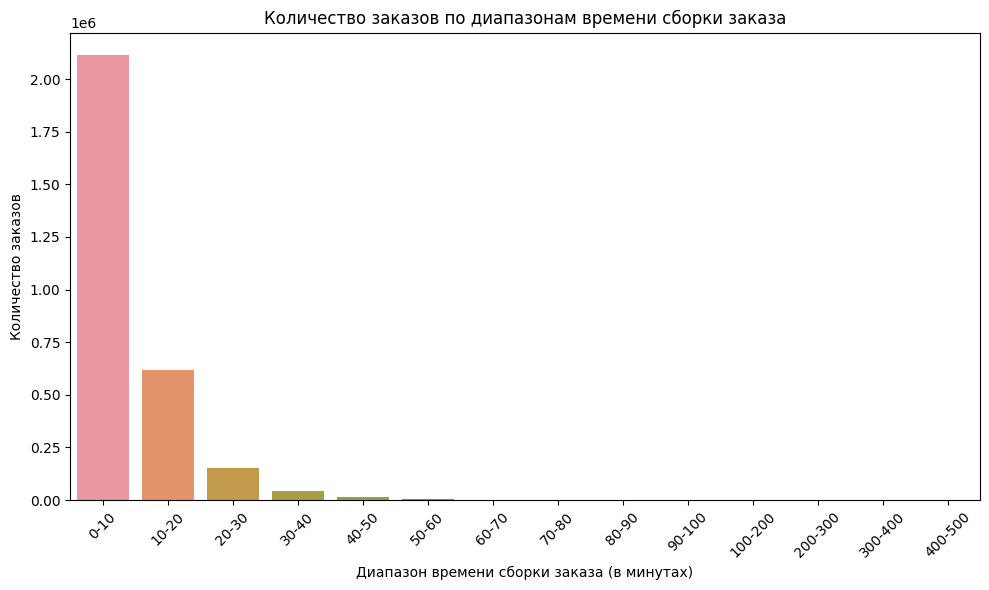

In [39]:
# Нарисуем график на обнаружение выбросов

# Добавляем новый столбец с округленным общим временем сборки заказа в минутах
df_converted_time['collecting_time_minutes'] = ((df_converted_time['date_ready'] - df_converted_time['date_collecting']).dt.total_seconds() / 60).round()
df_converted_time['collecting_time_minutes'] = df_converted_time['collecting_time_minutes'].astype(int)

# Определение диапазонов значений в столбце 'total_time_minutes'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200', '200-300', '300-400', '400-500']
df_converted_time['total_time_minutes_range'] = pd.cut(df_converted_time['collecting_time_minutes'], bins=bins, labels=labels)

# Группировка данных по диапазонам 'total_time_minutes_range' и подсчет количества заказов
order_counts_speed_min = df_converted_time.groupby('total_time_minutes_range').size()

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x=order_counts_speed_min.index, y=order_counts_speed_min.values)
plt.xlabel('Диапазон времени сборки заказа (в минутах)')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по диапазонам времени сборки заказа')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Посмотрим на квантили и среднее значения времени сборки в минутах
pd.DataFrame(df_converted_time['collecting_time_minutes'].describe(include=[np.number]))

collecting_time_minutes
count               2964648.00
mean                      8.88
std                       8.02
min                       0.00
25%                       4.00
50%                       7.00
75%                      11.00
max                    1186.00

In [41]:
# Посмотрим на 95 квантиль
print(df_converted_time['collecting_time_minutes'].quantile(0.95))

24.0


В среднем заказы собирают около 7 минут, обрежем выбросы до ,примерно, 95 перцентиля, т.е. до 30 минут.

In [42]:
# Оставим данные с максимальным временем сборки до 30 минут
df_less_than_30_minutes = df_converted_time[(df_converted_time['collecting_time'] >= 30) & (df_converted_time['collecting_time_minutes'] <= 30)].reset_index(drop=True)

In [43]:
df_less_than_30_minutes[(df_less_than_30_minutes['total_time_minutes_range'] == '40-50')]

Empty DataFrame
Columns: [order_id, shop_id, region, darkstore, date_ready, date_collecting, products_count, quantity_no_weight_products, weight_of_weight_products, marked_count, weight_count, pickup_takeaway, fast_food, mature_products, freeze_products, client_first_order, pay_on_packing, replacement_type, replacement_need_call, interval_delivery_enabled, shop_group, shop_timezone_offset, collecting_time, collecting_time_minutes, total_time_minutes_range]
Index: []

In [44]:
pd.DataFrame(round(df_less_than_30_minutes.isna().mean() * 100)).style.background_gradient('coolwarm')

In [45]:
# Вывод длины датафрейма
len(df_less_than_30_minutes)

2885585

In [46]:
# Извлечение часа из столбца 'date_collecting'
df_less_than_30_minutes['hour_of_day'] = df_less_than_30_minutes['date_collecting'].dt.hour
# Посмотрим на среднее время сборки по часам дня
pd.DataFrame(df_less_than_30_minutes.groupby('hour_of_day')['collecting_time'].median())

collecting_time
hour_of_day                 
0                     539.50
1                     489.00
2                     507.00
3                     524.00
4                     473.50
5                     519.50
6                     484.50
7                     573.00
8                     396.00
9                     406.00
10                    410.00
11                    411.00
12                    410.00
13                    408.00
14                    406.00
15                    399.00
16                    393.00
17                    388.00
18                    382.00
19                    370.00
20                    352.00
21                    330.00
22                    316.00
23                    385.00

* c **00:00** до **07:00** на сборку уходит около 500 сек
* с **08:00** до **16:00** на сборку уходит около 400 сек
* с **17:00** до **22:00** время сборки постепенно уменьшается с 388 сек до 316 сек
* с **23:00** время сборки увеличивается до 385 сек


Скорее всего, это связано с количеством сборщиков. Ночью сборщиков очевидно меньше и поэтому заказы собирают дольше.

In [47]:
# Посмотрим на среднее время сборки по часам дня
pd.DataFrame(df_less_than_30_minutes.groupby('hour_of_day')['order_id'].count())

order_id
hour_of_day          
0                 166
1                 323
2                 245
3                 199
4                 132
5                 134
6                 304
7                3523
8               59182
9              173325
10             205555
11             226173
12             232767
13             229105
14             224400
15             220870
16             226262
17             233721
18             244996
19             246062
20             212972
21             115723
22              26904
23               2542

* Больше всего заказов с **09:00** до **21:00**, далее заказы линейно уменьшаются.
* c **00:00** до **06:00** кол-во заказов не превышает 323.
* Начиная с **07:00** кол-во заказов увеличиваются.

Заказов ночью меньше и собирают их дольше, соотвественно, и сборщиков нужно меньше.


In [48]:
# Добавим категорию времени суток
bins = [-1, 3, 11, 16, 23]  # Границы для "утро", "день" и "ночь"
labels = ["ночь", "утро", "день", 'вечер']
df_less_than_30_minutes['day_category'] = pd.cut(df_less_than_30_minutes['hour_of_day'], bins=bins, labels=labels)

In [49]:
# Проверим изменения
df_less_than_30_minutes.sample(5)

order_id shop_id      region  darkstore  \
1655879  64d4eafed6bfb14b0ed8a0fc    5027         spb      False   
1341182  64d2800e5591462a2dbf9685    2273  msk_region      False   
2079724  64d79fafd5477b044e69a7b3   10947         msk       True   
104085   64ca514a9766181e08104ebd    3354        tver      False   
495331   64ccf86a37242db8e0702a5f    4318         msk      False   

                 date_ready     date_collecting  products_count  \
1655879 2023-08-10 17:02:06 2023-08-10 16:52:14              21   
1341182 2023-08-08 20:50:31 2023-08-08 20:49:18               2   
2079724 2023-08-12 18:13:37 2023-08-12 18:07:58               6   
104085  2023-08-02 16:00:27 2023-08-02 15:51:32              13   
495331  2023-08-04 16:11:27 2023-08-04 16:09:02               7   

         quantity_no_weight_products  weight_of_weight_products  marked_count  \
1655879                           21                       2.50             7   
1341182                            7                       0.00             0   
2079724                            8                       0.00             4   
104085                            13                       1.50             4   
495331                            11                       0.00             3   

         weight_count  pickup_takeaway  fast_food  mature_products  \
1655879             7             True      False            False   
1341182             0            False      False            False   
2079724             0            False      False            False   
104085              3            False      False            False   
495331              0            False      False            False   

         freeze_products  client_first_order  pay_on_packing replacement_type  \
1655879             True               False            True         dont_ask   
1341182            False               False           False              ask   
2079724             True               False           False              ask   
104085             False               False           False              ask   
495331             False               False           False              ask   

         replacement_need_call  interval_delivery_enabled    shop_group  \
1655879                   True                      False  fivedelivery   
1341182                  False                      False  fivedelivery   
2079724                  False                      False  fivedelivery   
104085                   False                      False  fivedelivery   
495331                   False                      False  fivedelivery   

        shop_timezone_offset  collecting_time  collecting_time_minutes  \
1655879      0 days 03:00:00              592                       10   
1341182      0 days 03:00:00               73                        1   
2079724      0 days 03:00:00              339                        6   
104085       0 days 03:00:00              535                        9   
495331       0 days 03:00:00              145                        2   

        total_time_minutes_range  hour_of_day day_category  
1655879                     0-10           16         день  
1341182                     0-10           20        вечер  
2079724                     0-10           18        вечер  
104085                      0-10           15         день  
495331                      0-10           16         день

In [50]:
# Проверим еще раз зависимость кол-ва заказов от времени суток
pd.DataFrame(df_less_than_30_minutes.groupby('day_category')['order_id'].count())

order_id
day_category          
ночь               933
утро            668328
день           1133404
вечер          1082920

Действительно, ночью меньше всего заказов, скорее всего не все магазины работают по ночам, да и большенство клиентов спит в это время. 
Также есть фичач отложенных заказов, которые нужно собрать к утру, поэтому кол-во заказов прибавляется к утру, дню или вечеру.

In [51]:
# Извлечем день недели из столбца 'date_collecting'
df_less_than_30_minutes['day_of_week'] = df_less_than_30_minutes['date_collecting'].dt.strftime('%A')

In [52]:
# Проверим изменения
df_less_than_30_minutes.sample(5)

order_id shop_id      region  darkstore  \
2019470  64d76c35a98e1434540061e6     168         kzn      False   
536943   64cd1e95a8a1303b012ec3dd    3203         msk      False   
1121337  64d10ef4d6bfb1813ac79c25    9363  msk_region      False   
1947613  64d73279d5477b735663298c    4660         nsb      False   
398066   64cc9a5c28b8107a74c11681    7459          sm      False   

                 date_ready     date_collecting  products_count  \
2019470 2023-08-12 14:31:46 2023-08-12 14:25:46               4   
536943  2023-08-04 19:03:16 2023-08-04 18:52:36              11   
1121337 2023-08-07 18:46:58 2023-08-07 18:34:23              15   
1947613 2023-08-12 14:38:32 2023-08-12 14:19:33              23   
398066  2023-08-04 10:34:23 2023-08-04 10:30:35               3   

         quantity_no_weight_products  weight_of_weight_products  marked_count  \
2019470                            1                       0.55             0   
536943                            13                       0.80             2   
1121337                           18                       0.50             4   
1947613                           28                       2.70             2   
398066                            12                       0.00             0   

         weight_count  pickup_takeaway  fast_food  mature_products  \
2019470             3             True      False            False   
536943              3            False      False            False   
1121337             1             True      False            False   
1947613             5            False      False            False   
398066              1             True      False            False   

         freeze_products  client_first_order  pay_on_packing replacement_type  \
2019470            False               False            True           delete   
536943             False               False           False              ask   
1121337             True               False            True           delete   
1947613            False               False           False           delete   
398066             False               False            True         dont_ask   

         replacement_need_call  interval_delivery_enabled    shop_group  \
2019470                   True                      False           tsx   
536943                   False                      False  fivedelivery   
1121337                   True                      False  fivedelivery   
1947613                  False                      False  fivedelivery   
398066                    True                      False  fivedelivery   

        shop_timezone_offset  collecting_time  collecting_time_minutes  \
2019470      0 days 03:00:00              360                        6   
536943       0 days 03:00:00              640                       11   
1121337      0 days 03:00:00              755                       13   
1947613      0 days 07:00:00             1139                       19   
398066       0 days 04:00:00              228                        4   

        total_time_minutes_range  hour_of_day day_category  day_of_week  
2019470                     0-10           14         день      суббота  
536943                     10-20           18        вечер      пятница  
1121337                    10-20           18        вечер  понедельник  
1947613                    10-20           14         день      суббота  
398066                      0-10           10         утро      пятница

In [53]:
# Посчитаем кол-во заказов по часам и дням недели
pd.DataFrame(df_less_than_30_minutes.groupby(['day_of_week', 'day_category'])['order_id'].count())

order_id
day_of_week day_category          
воскресенье ночь               125
            утро             99390
            день            175549
            вечер           147062
вторник     ночь               125
            утро             82140
            день            139648
            вечер           143872
понедельник ночь               128
            утро             83056
            день            141048
            вечер           146836
пятница     ночь               116
            утро             89901
            день            149130
            вечер           144988
среда       ночь               161
            утро            128855
            день            215419
            вечер           217458
суббота     ночь               157
            утро            100568
            день            165147
            вечер           132824
четверг     ночь               121
            утро             84418
            день            147463
            вечер           149880

Больше всего заказов было сделано в среду - сложно судить с чем это связано, т.к. данные взяты всего за две недели.

In [54]:
# Посчитаем среднее время сборки в секундах по часам и дням недели
pd.DataFrame(df_less_than_30_minutes.groupby(['day_of_week', 'day_category'])['collecting_time'].median())

collecting_time
day_of_week day_category                 
воскресенье ночь                   481.00
            утро                   412.00
            день                   408.00
            вечер                  366.00
вторник     ночь                   558.00
            утро                   399.00
            день                   392.00
            вечер                  360.00
понедельник ночь                   523.50
            утро                   414.00
            день                   404.00
            вечер                  372.00
пятница     ночь                   540.50
            утро                   409.00
            день                   409.00
            вечер                  377.00
среда       ночь                   487.00
            утро                   398.00
            день                   391.00
            вечер                  363.00
суббота     ночь                   470.00
            утро                   426.00
            день                   420.00
            вечер                  364.00
четверг     ночь                   557.00
            утро                   405.00
            день                   402.00
            вечер                  373.00

Вечером заказы собирают быстрее.

In [55]:
# создаём отчёт
profile = df_less_than_30_minutes.profile_report(progress_bar=False)
# сохраним отчет
# profile.to_file("orders.html")

- `darkstore`, `interval_delivery_enabled` - имеют сильный дисбаланс, превалирует значение *False*, признаки лучше удалить, т.к. сильного вляния на предсказание не будет
- `fast_food`, `mature_products`, `client_first_order` - на 100% превалирует значение *False*, от признаков лучше избавиться, т.к. влияния не наблюдается

- `replacement_need_call`, `replacement_type`, `pay_on_packing`, `freeze_products`, `pickup_takeaway` - булева поля более менее адекватны, проверим скорость сборки относительно целевого признака

In [56]:
pd.DataFrame(df_less_than_30_minutes.groupby(['replacement_need_call'])['collecting_time'].median())

collecting_time
replacement_need_call                 
False                           387.00
True                            399.00

флаг звонящей сборки особо не влияет на скорость, средняя разница почти 10 секунд, но признак можно пробовать оставить

In [57]:
pd.DataFrame(df_less_than_30_minutes.groupby(['replacement_type'])['collecting_time'].median())

collecting_time
replacement_type                 
ask                        388.00
delete                     386.00
dont_ask                   422.00

- между *ask* и *delete* особо разницы нету
- если замены не спрашивают (*dont_ask*), то скорость сборки медленнее

признак оставляем

In [58]:
pd.DataFrame(df_less_than_30_minutes.groupby(['pay_on_packing'])['collecting_time'].median())

collecting_time
pay_on_packing                 
False                    341.00
True                     450.00

При оплате на фасовке скорость сборки становится медленнее. Признак оставляем.

In [59]:
pd.DataFrame(df_less_than_30_minutes.groupby(['freeze_products'])['collecting_time'].median())

collecting_time
freeze_products                 
False                     359.00
True                      480.00

Если в корзине есть замороженные продукты, то скорость сборки становится медленнее. Признак оставляем.

In [60]:
pd.DataFrame(df_less_than_30_minutes.groupby(['pickup_takeaway'])['collecting_time'].median())

collecting_time
pickup_takeaway                 
False                     392.00
True                      389.00

самовывоз практически не влияет на скорость сборки, признак можно убрать

In [61]:
pd.DataFrame(df_less_than_30_minutes.groupby(['shop_group'])['collecting_time'].median())

collecting_time
shop_group                   
chizhik                380.00
fivedelivery           347.00
tsx                    553.00

* в чижике сборка в среднем быстрее, т.к. данных в разы меньше, чем у других групп магагизнов, сложно оценить достоверность
* в пятрочке собирают заказы быстрее, потому что кол-во магазинов больше и площадь магазина обычно меньше, чем в перекрестке

In [62]:
# Создадим новую таблицу для обучения без лишних признаков
df_for_learn = df_less_than_30_minutes.drop(['order_id', 'shop_id', 'date_collecting', 'date_ready',
                                            'collecting_time_minutes', 'total_time_minutes_range',
                                            'pickup_takeaway', 'interval_delivery_enabled', 'fast_food', 
                                            'mature_products', 'client_first_order'], axis=1)

In [63]:
# Проверим изменения
df_for_learn.info()
df_for_learn.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885585 entries, 0 to 2885584
Data columns (total 17 columns):
 #   Column                       Dtype          
---  ------                       -----          
 0   region                       object         
 1   darkstore                    bool           
 2   products_count               uint16         
 3   quantity_no_weight_products  uint16         
 4   weight_of_weight_products    float32        
 5   marked_count                 uint16         
 6   weight_count                 uint16         
 7   freeze_products              bool           
 8   pay_on_packing               bool           
 9   replacement_type             object         
 10  replacement_need_call        bool           
 11  shop_group                   object         
 12  shop_timezone_offset         timedelta64[ns]
 13  collecting_time              int64          
 14  hour_of_day                  int32          
 15  day_category                 cat

region  darkstore  products_count  quantity_no_weight_products  \
1714335         vrn      False               4                            3   
1740858        oren      False              13                           14   
1009722  msk_region      False               8                           11   
2138345  msk_region      False              12                           23   
1156789         kzn      False               8                            9   

         weight_of_weight_products  marked_count  weight_count  \
1714335                       0.80             0             1   
1740858                       0.00             1             0   
1009722                       0.00             3             0   
2138345                       0.00             4             1   
1156789                       0.00             5             0   

         freeze_products  pay_on_packing replacement_type  \
1714335            False            True              ask   
1740858            False           False              ask   
1009722             True           False              ask   
2138345            False            True              ask   
1156789             True           False           delete   

         replacement_need_call    shop_group shop_timezone_offset  \
1714335                  False           tsx      0 days 03:00:00   
1740858                  False  fivedelivery      0 days 05:00:00   
1009722                  False  fivedelivery      0 days 03:00:00   
2138345                  False           tsx      0 days 03:00:00   
1156789                  False  fivedelivery      0 days 03:00:00   

         collecting_time  hour_of_day day_category  day_of_week  
1714335              256           20        вечер      четверг  
1740858              658           11         утро      пятница  
1009722              682           10         утро  понедельник  
2138345              544            9         утро  воскресенье  
1156789              319           21        вечер  понедельник

In [64]:
# Зададим типы данных вручную                                            
df_for_learn = df_for_learn.astype({'region': 'category', 'replacement_type': 'category', 'shop_group': 'category', 'hour_of_day': 'category', 
                                     'day_of_week': 'category'})

In [65]:
df_for_learn.dtypes

region                                category
darkstore                                 bool
products_count                          uint16
quantity_no_weight_products             uint16
weight_of_weight_products              float32
marked_count                            uint16
weight_count                            uint16
freeze_products                           bool
pay_on_packing                            bool
replacement_type                      category
replacement_need_call                     bool
shop_group                            category
shop_timezone_offset           timedelta64[ns]
collecting_time                          int64
hour_of_day                           category
day_category                          category
day_of_week                           category
dtype: object

Сначала обучим без регионов, потом с регионами, чтобы посмотреть влияет ли данный признак на качество.

## Обучение моделей

Разделим датасет на тренировочную и тестовую в соотношении 4 к 1, а так же предварительно перемешаем дополнительно наблюдения, так как в изначальном датасете все данные были распределены по времени:

In [66]:
# Создадим новую таблицу для обучения без часа дня
df_for_learn = df_for_learn.drop(['day_category'], axis=1, errors='ignore')

In [67]:
# Сохранение DataFrame в CSV файл
csv_filename = 'data/df_for_learn.csv'
df_for_learn.to_csv(csv_filename, index=False)

In [68]:
df_for_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885585 entries, 0 to 2885584
Data columns (total 16 columns):
 #   Column                       Dtype          
---  ------                       -----          
 0   region                       category       
 1   darkstore                    bool           
 2   products_count               uint16         
 3   quantity_no_weight_products  uint16         
 4   weight_of_weight_products    float32        
 5   marked_count                 uint16         
 6   weight_count                 uint16         
 7   freeze_products              bool           
 8   pay_on_packing               bool           
 9   replacement_type             category       
 10  replacement_need_call        bool           
 11  shop_group                   category       
 12  shop_timezone_offset         timedelta64[ns]
 13  collecting_time              int64          
 14  hour_of_day                  category       
 15  day_of_week                  cat

In [78]:
df_for_learn = df_for_learn.drop(columns=['shop_timezone_offset'])

In [79]:
df_for_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885585 entries, 0 to 2885584
Data columns (total 15 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   region                       category
 1   darkstore                    bool    
 2   products_count               uint16  
 3   quantity_no_weight_products  uint16  
 4   weight_of_weight_products    float32 
 5   marked_count                 uint16  
 6   weight_count                 uint16  
 7   freeze_products              bool    
 8   pay_on_packing               bool    
 9   replacement_type             category
 10  replacement_need_call        bool    
 11  shop_group                   category
 12  collecting_time              int64   
 13  hour_of_day                  category
 14  day_of_week                  category
dtypes: bool(4), category(5), float32(1), int64(1), uint16(4)
memory usage: 82.6 MB


In [80]:
# Для установки начального состояния генератора случайных чисел. 
# Это позволяет воспроизводить результаты при каждом запуске модели с одним и тем же значением RANDOM_STATE
RANDOM_STATE = 42

df_shuffled = shuffle(df_for_learn, random_state=RANDOM_STATE)

df_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2885585 entries, 1628750 to 2219110
Data columns (total 15 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   region                       category
 1   darkstore                    bool    
 2   products_count               uint16  
 3   quantity_no_weight_products  uint16  
 4   weight_of_weight_products    float32 
 5   marked_count                 uint16  
 6   weight_count                 uint16  
 7   freeze_products              bool    
 8   pay_on_packing               bool    
 9   replacement_type             category
 10  replacement_need_call        bool    
 11  shop_group                   category
 12  collecting_time              int64   
 13  hour_of_day                  category
 14  day_of_week                  category
dtypes: bool(4), category(5), float32(1), int64(1), uint16(4)
memory usage: 104.6 MB


In [81]:
# Разделим данные на признаки (features) и целевую переменную (target)
df_features = df_shuffled.drop(['collecting_time'], axis=1)
df_target = df_shuffled['collecting_time']

# Разделим данные на тренировочную и тестовую выборки с соотношением 4 к 1
train_features, test_features, train_target, test_target = train_test_split(df_features,
                                                                            df_target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [82]:
test_features

region  darkstore  products_count  quantity_no_weight_products  \
2664708         msk      False               5                            5   
1125519         msk      False               8                           12   
1334815         bzk      False              20                           18   
1172752         nsb      False               4                            6   
1251209         msk      False              14                           13   
...             ...        ...             ...                          ...   
826595   spb_region      False               9                           13   
1400153          sm      False               3                            3   
1210086         spb      False              18                           15   
992061          rnd      False               5                            6   
84283         ulyan      False               8                            7   

         weight_of_weight_products  marked_count  weight_count  \
2664708                       3.70             1             2   
1125519                       0.00             4             2   
1334815                       1.93             3             5   
1172752                       0.50             0             2   
1251209                       2.40             1             3   
...                            ...           ...           ...   
826595                        0.00             1             1   
1400153                       0.00             0             0   
1210086                       1.60             3             3   
992061                        0.60             2             1   
84283                         0.50             2             1   

         freeze_products  pay_on_packing replacement_type  \
2664708            False           False              ask   
1125519            False            True           delete   
1334815            False            True           delete   
1172752             True            True           delete   
1251209            False            True              ask   
...                  ...             ...              ...   
826595             False            True           delete   
1400153            False            True              ask   
1210086             True            True           delete   
992061             False            True              ask   
84283              False           False              ask   

         replacement_need_call    shop_group hour_of_day  day_of_week  
2664708                  False  fivedelivery          19      вторник  
1125519                  False           tsx          18  понедельник  
1334815                   True           tsx          20      вторник  
1172752                   True  fivedelivery          12      вторник  
1251209                  False           tsx          14      вторник  
...                        ...           ...         ...          ...  
826595                    True  fivedelivery          12  воскресенье  
1400153                  False           tsx          12        среда  
1210086                  False           tsx          11      вторник  
992061                   False           tsx           9  понедельник  
84283                    False  fivedelivery          15        среда  

[721397 rows x 14 columns]

In [72]:
# # Создание нового объекта
# unknown_region = pd.DataFrame({ 
#     'region': ['unknown_region'],
#     'products_count': [5],
#     'quantity_no_weight_products': [5],
#     'weight_of_weight_products': [3.70],
#     'weight_count': [2],
#     'freeze_products': [False],
#     'pay_on_packing': [False],
#     'replacement_type': ['ask'],
#     'replacement_need_call': [False],
#     'shop_group': ['fivedelivery'],
#     'hour_of_day': [19],
#     'day_of_week': ['вторник']
# })

# # Добавление нового объекта в тестовую выборку
# test_features = pd.concat([test_features, unknown_region], ignore_index=True)

# # Создание нового таргета
# unknown_target = pd.Series([262])

# # Добавление нового таргета в тестовый таргет
# test_target = pd.concat([test_target, unknown_target], ignore_index=True)

# # Проверка результатов
# print(test_features)
# print(test_target)

In [83]:
# Проверим, что данные разделились правильно
print(train_features.shape)
print(test_features.shape)

(2164188, 14)
(721397, 14)


In [84]:
# Создание списка уникальных значений регионов в тренировочной выборке
train_regions = train_features['region'].unique().tolist()

# Создание списка уникальных значений регионов в тестовой выборке
test_regions = test_features['region'].unique().tolist()

# Сравнение списков
if set(train_regions) == set(test_regions):
    print("Названия регионов совпадают в тренировочной и тестовой выборке.")
else:
    print("Названия регионов различаются в тренировочной и тестовой выборке.")

Названия регионов совпадают в тренировочной и тестовой выборке.


In [85]:
encoded_features = ['replacement_type', 'shop_group', 'region', 'hour_of_day', 'day_of_week']

# Создание ColumnTransformer для OneHotEncoding
col_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), encoded_features)
    ],
    remainder='passthrough'
)

# Создание объекта модели с заранее определенными параметрами
cat = CatBoostRegressor(max_depth=8, learning_rate=0.1, verbose=False)

In [86]:
pipeline = Pipeline([
    ('unknown_imputer', UnknownCategoryImputer(column='region', default_value='msk_region')),
    ('label_encoder', MultiColumnLabelEncoder(columns=encoded_features)),
    ('col_transformer', col_transformer),
    ('model', cat)
])

# Обучение пайплайна
pipeline.fit(train_features, train_target)

Unknown regions count: 0
Features Encoded


Pipeline(steps=[('unknown_imputer',
                 UnknownCategoryImputer(column='region',
                                        default_value='msk_region')),
                ('label_encoder',
                 <helpers.helpers.MultiColumnLabelEncoder object at 0x1a9cb9990>),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['replacement_type',
                                                   'shop_group', 'region',
                                                   'hour_of_day',
                                                   'day_of_week'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x1a3bf9310>)])

In [ ]:
feature_names = list(train_features.columns) 

# Получение общей важности признаков
feature_importances = pipeline.named_steps['model'].get_feature_importance(type='PredictionValuesChange')

# Создание списка пар (имя признака, важность) и сортировка по убыванию важности
sorted_feature_importances = sorted(zip(feature_names, feature_importances), key=lambda x: -x[1])

# Вывод отсортированных важностей признаков
print("Feature Importances (Sorted):")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature Importances (Sorted):
quantity_no_weight_products: 28.603025515207193
products_count: 7.83675326694063
region: 0.4163070093034698
darkstore: 0.16822405188646766
hour_of_day: 0.049253662609342844
replacement_need_call: 0.01958594945460059
marked_count: 0.015411492170125532
weight_count: 0.009804211433440546
pay_on_packing: 0.007941324246843332
day_of_week: 0.007726373594074411
shop_group: 0.0034107294623708876
freeze_products: 0.0030102014619861435
replacement_type: 0.00044167743190258284
weight_of_weight_products: 0.0


In [ ]:
# Получение предсказаний
train_predictions = pipeline.predict(train_features)
# Вычисляем MAE
mae = mean_absolute_error(train_target, train_predictions)
#Отображаем MAE
print('MAE обученной модели:', mae)

Unknown regions count: 0
Features Encoded
MAE обученной модели: 171.4504279242572


In [ ]:
# Сохранение модели
model_filename = 'catboost_model.pkl'
joblib.dump(pipeline, model_filename)


# Загрузка модели
catboost_model = joblib.load(model_filename)

In [ ]:
# Делаем простые предсказания
dummy = DummyRegressor(strategy='mean')
dummy.fit(train_features, train_target)
dummy_predictions = dummy.predict(test_features)

# Вычисляем MAE для dummy модели
dummy_mae = mean_absolute_error(test_target, dummy_predictions)
print('MAE dummy модели:', dummy_mae)

MAE dummy модели: 275.26901683946625


In [ ]:
# Получаем предсказания от основной модели
main_predictions = pipeline.predict(test_features)
# Вычисляем MAE для нашей основной модели
main_mae = mean_absolute_error(test_target, main_predictions)
print('MAE основной модели:', main_mae)

Unknown regions count: 0
Features Encoded
MAE основной модели: 172.53766413090506


In [ ]:
# Создадим таблицу по тестовой выборке
df_test_predict = pd.concat([test_features, test_target], axis=1)

In [ ]:
# Добавляем столбец с предсказаниями
df_test_predict['predicted_cat'] = main_predictions

In [ ]:
# Проверим изменения
df_test_predict

region  darkstore  products_count  quantity_no_weight_products  \
2664708         msk      False               5                            5   
1125519         msk      False               8                           12   
1334815         bzk      False              20                           18   
1172752         nsb      False               4                            6   
1251209         msk      False              14                           13   
...             ...        ...             ...                          ...   
826595   spb_region      False               9                           13   
1400153          sm      False               3                            3   
1210086         spb      False              18                           15   
992061          rnd      False               5                            6   
84283         ulyan      False               8                            7   

         weight_of_weight_products  marked_count  weight_count  \
2664708                       3.70             1             2   
1125519                       0.00             4             2   
1334815                       1.93             3             5   
1172752                       0.50             0             2   
1251209                       2.40             1             3   
...                            ...           ...           ...   
826595                        0.00             1             1   
1400153                       0.00             0             0   
1210086                       1.60             3             3   
992061                        0.60             2             1   
84283                         0.50             2             1   

         freeze_products  pay_on_packing replacement_type  \
2664708            False           False              ask   
1125519            False            True           delete   
1334815            False            True           delete   
1172752             True            True           delete   
1251209            False            True              ask   
...                  ...             ...              ...   
826595             False            True           delete   
1400153            False            True              ask   
1210086             True            True           delete   
992061             False            True              ask   
84283              False           False              ask   

         replacement_need_call    shop_group hour_of_day  day_of_week  \
2664708                  False  fivedelivery          19      вторник   
1125519                  False           tsx          18  понедельник   
1334815                   True           tsx          20      вторник   
1172752                   True  fivedelivery          12      вторник   
1251209                  False           tsx          14      вторник   
...                        ...           ...         ...          ...   
826595                    True  fivedelivery          12  воскресенье   
1400153                  False           tsx          12        среда   
1210086                  False           tsx          11      вторник   
992061                   False           tsx           9  понедельник   
84283                    False  fivedelivery          15        среда   

         collecting_time  predicted_cat  
2664708              262         283.76  
1125519              392         569.35  
1334815             1108         998.00  
1172752              208         288.04  
1251209             1712         888.27  
...                  ...            ...  
826595               435         363.65  
1400153              177         235.34  
1210086             1246        1031.39  
992061               157         412.59  
84283                272         300.00  

[721397 rows x 16 columns]

In [ ]:
# Добавим столбец с ошибкой предсказания
df_test_predict['diff'] = abs(df_test_predict['collecting_time'] - df_test_predict['predicted_cat'])

In [ ]:
# Посмотрим на кол-во данных, чья ошибка предсказания больше или равна 100 секундам
df_test_predict[df_test_predict['diff'] <= 100]

region  darkstore  products_count  quantity_no_weight_products  \
2664708         msk      False               5                            5   
1172752         nsb      False               4                            6   
1731739         msk      False              11                           41   
847268   spb_region      False               7                           17   
186518      irkutsk      False               9                           11   
...             ...        ...             ...                          ...   
710873          msk      False              15                           42   
2045675        tmbv      False               6                            8   
826595   spb_region      False               9                           13   
1400153          sm      False               3                            3   
84283         ulyan      False               8                            7   

         weight_of_weight_products  marked_count  weight_count  \
2664708                       3.70             1             2   
1172752                       0.50             0             2   
1731739                       0.00             5             0   
847268                        0.00             3             1   
186518                        0.00             0             0   
...                            ...           ...           ...   
710873                        1.30             1             5   
2045675                       0.00             3             0   
826595                        0.00             1             1   
1400153                       0.00             0             0   
84283                         0.50             2             1   

         freeze_products  pay_on_packing replacement_type  \
2664708            False           False              ask   
1172752             True            True           delete   
1731739            False           False              ask   
847268             False           False              ask   
186518             False           False           delete   
...                  ...             ...              ...   
710873             False           False           delete   
2045675            False           False              ask   
826595             False            True           delete   
1400153            False            True              ask   
84283              False           False              ask   

         replacement_need_call    shop_group hour_of_day  day_of_week  \
2664708                  False  fivedelivery          19      вторник   
1172752                   True  fivedelivery          12      вторник   
1731739                  False  fivedelivery           8      пятница   
847268                   False  fivedelivery          13  воскресенье   
186518                   False  fivedelivery           8      четверг   
...                        ...           ...         ...          ...   
710873                   False  fivedelivery          17      суббота   
2045675                  False  fivedelivery          15      суббота   
826595                    True  fivedelivery          12  воскресенье   
1400153                  False           tsx          12        среда   
84283                    False  fivedelivery          15        среда   

         collecting_time  predicted_cat  diff  
2664708              262         283.76 21.76  
1172752              208         288.04 80.04  
1731739              536         537.09  1.09  
847268               291         343.78 52.78  
186518               357         399.72 42.72  
...                  ...            ...   ...  
710873               767         816.59 49.59  
2045675              196         190.62  5.38  
826595               435         363.65 71.35  
1400153              177         235.34 58.34  
84283                272         300.00 28.00  

[298624 rows x 17 columns]

In [ ]:
# Посмотрим на статистическое описание ошибки предсказания
df_test_predict['diff'].describe()

count   721397.00
mean       172.54
std        172.37
min          0.00
25%         60.47
50%        123.07
75%        223.21
max       1668.46
Name: diff, dtype: float64

In [ ]:
# Сохранение DataFrame в CSV файл
csv_filename = 'data/df_test_predict.csv'
df_test_predict.to_csv(csv_filename, index=False)

In [ ]:
# Посмотрим на 90 квантиль
print(df_test_predict['diff'].quantile(.9))

374.0871686875534


In [ ]:
# Посчитаем процент ошибки предсказания больше или равно 500 секундам
100 /len(df_test_predict) * len(df_test_predict[df_test_predict['diff'] <= 500])

94.74810679833712

In [ ]:
# Обрежем данные до 500 секунд
df_test_predict_cut = df_test_predict[df_test_predict['diff'] <= 500]

# Категории для разницы времени сборки с интервалом 10 секунд
bins = list(range(0, 501, 10))  # Интервалы от 0 до 500 секунд с шагом 10
labels = [f'{i+10}' for i in range(0, 500, 10)]  # Метки для категорий
df_test_predict_cut['time_bin'] = pd.cut(df_test_predict_cut['diff'], bins=bins, labels=labels)

# Ппроцент заказов в каждой категории и их кумулятивная сумма
percent_orders_by_bin = df_test_predict_cut['time_bin'].value_counts(normalize=True).sort_index() * 100
cumulative_percent_orders = np.cumsum(percent_orders_by_bin)

In [ ]:
# Таблица для построения графика
data = pd.DataFrame({'collecting': cumulative_percent_orders.index, 'percent_orders': cumulative_percent_orders})

# Plotly для построения интерактивной кумулятивной кривой
fig = px.line(data, x='collecting', y='percent_orders', title='Соотношение заказов по разнице времени сборки (категории)')
fig.update_traces(line=dict(color='#00BFA5'))
fig.update_xaxes(title_text='Ошибка предсказания (секунды)')
fig.update_yaxes(title_text='Процент заказов')
fig.show()

## Итоговый вывод

Модель принимает на вход данные:

- `region` - регион магазина, в котором собирался заказ;
- `products_count` - общее кол-во уникальных позиций в корзине;
- `marked_count` - кол-во уникальных позиций с маркировкой;
- `weight_count` - кол-во уникальных весовых позиций;
- `quantity_no_weight_products` - кол-во штук всех невесовых товаров;
- `weight_of_weight_products` - общий вес всех весовых товаров в корзине;
- `darkstore` - флаг является ли магазин даркстором;
- `freeze_products` - флаг присутствия товаров с заморозкой;
- `pay_on_packing` - флаг оплаты на фасовке;
- `replacement_type` - категория типа замен;
- `replacement_need_call` - флаг включена ли звонящая сборка;
- `shop_group` - наименование группы магазинов, в которых собирался заказ;
- `hour_of_day` - категория часа дня;
- `day_category` - категория дня недели.


Лучшие параметры модели **CatBoost**:
- `learning_rate`: 0.1, `max_depth`: 8

Качество предсказания:
- MAE (средняя абсолютная ошибка): **~173 сек**,
- Медиана ошибки: **~123 cек**

Что было сделано с признаками перед обучением:
- Преобразовали признаки в типы данных, которые соотвествуют логике данных;
- Мы обрезали около 100к данных, чье время сборки было больше 30 минут, т.к. такие заказы довольно редкое явление и могли помешать машине найти закономерность;
- Категориальные данные были закодированы с помощью *Label_Encoding* и *OHE*.

Основные проблемы:
- Данные предоставлены за короткий период - **2 недели**, мало для исследовательского анализа т.к. данные временные, однако данных достаточно для тестового обучения и предоставления хорошего результата.
- Были бы полезны данные: 
    - топ магазинов/складов, регионов и сборщиков по времени сборки,
    - категории каждого товара,
    - данные за один год, чтобы посмотреть на сезонность и тренды.

**Примечание:** cравнение текущего балансировщика и балансировщика сделанного на ml можно подробнее рассмотреть в ноутбуке `collecting_vs.ipynb`